# Movie Sentiment Analysis: Convolutional Neural Network

## Import and preprocess data

In [1]:
import pandas as pd
import re
import numpy as np

movie_reviews = pd.read_csv("data/IMDB_Dataset.csv")

tag_re = re.compile(r'<[^>]+>')
def remove_tags(text):
    return tag_re.sub('', text)

def preprocess(sentence):
    pp_sentence = remove_tags(sentence)
    pp_sentence = re.sub('[^a-zA-Z]', ' ', pp_sentence)
    pp_sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', pp_sentence)
    pp_sentence = re.sub(r'\s+', ' ', pp_sentence)
    return pp_sentence

review_sentences = list(movie_reviews['review']) # list the reviews

X = []
for sentence in review_sentences:
    X.append(preprocess(sentence))
    
review_labels = list(map(lambda s: 1 if s=="positive" else 0, movie_reviews['sentiment'])) # list the sentiments

y = np.array(review_labels)

## Prepare training and testing data, and the embedding layer

In [2]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray, zeros

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 # +1 because of reserved 0 index
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

embedding_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embedding_dictionary[word] = vector
    
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vector = embedding_dictionary.get(word)
    if vector is not None:
        embedding_matrix[index] = vector
        
print(embedding_matrix.shape)

Using TensorFlow backend.


(92547, 100)


# Text Classification model: Convolutional Neural Network
* **Sequential model**
* one **embedding layer**
* **1D convolutional layer**
    * features = 128
    * kernel size = 5
    * activation = relu
* **Global max pooling layer**
* **Dense layer**
    * Activation = sigmoid

In [3]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

reviews_model = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]*100, '%')
print("Test Accuracy:", score[1]*100, '%')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 11s 334us/step - loss: 0.4958 - acc: 0.7583 - val_loss: 0.3914 - val_acc: 0.8216
Epoch 2/6
32000/32000 [======================

## Plot Accuracy and Loss

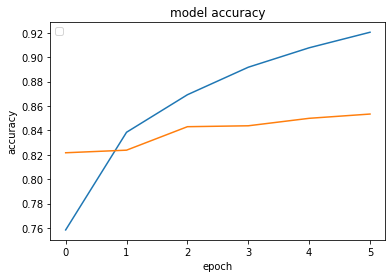

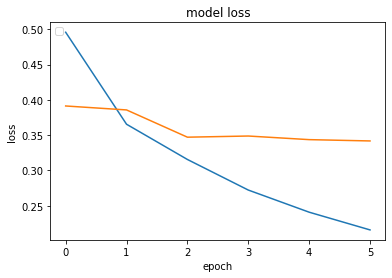

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

plt.plot(reviews_model.history['acc'])
plt.plot(reviews_model.history['val_acc'])

plt.show()

plt.figure()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

plt.plot(reviews_model.history['loss'])
plt.plot(reviews_model.history['val_loss'])

plt.show()

## Save the model

In [5]:
import pickle

filename = 'model_CNN.sav'
pickle.dump(model, open(filename, 'wb'))